In [1]:
import spacy
from collections import Counter, OrderedDict, defaultdict
from datasets import load_dataset
from elasticsearch import Elasticsearch
from spacy.tokenizer import Tokenizer
import pandas as pd
import matplotlib.pyplot as plt

C:\Users\karol\anaconda3\envs\NLP_spacy2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ds = load_dataset("clarin-knext/fiqa-pl", "corpus")
df=pd.DataFrame(ds['corpus'])
df = df.sample(n=1000)
text_list = [text for text in df['text']]

In [3]:
nlp = spacy.load("pl_core_news_sm")

def extract_capitalized_expressions(doc):
    expressions = []
    for sent in doc.sents:
        consecutive_capitalized = []
        for i, token in enumerate(sent): # handling one sentence at a time
            # checking if it's not the first word in the sentence, it's alphabetic, and it's lemmatization is capitalized
            if i > 0 and token.is_alpha and token.lemma_[0].isupper():
                consecutive_capitalized.append(token.lemma_)
            else:
                # If we reach a non-capitalized word, we check if we have a valid expression
                if len(consecutive_capitalized) > 1:
                    expressions.append(" ".join(consecutive_capitalized))
                consecutive_capitalized = []
        # Final check in case the sentence ends with a capitalized sequence
        if len(consecutive_capitalized) > 1:
            expressions.append(" ".join(consecutive_capitalized))
    return expressions

In [4]:
entities = []
for text in text_list:
    doc = nlp(text)
    expressions = extract_capitalized_expressions(doc)
    entities.extend(expressions)

print("Entity count:", len(entities))

Entity count: 337


Counting and sorting detected expressions, then extracting the 50 most frequent ones.

In [5]:
from collections import defaultdict
from itertools import islice

occurances = defaultdict(int)
for entity in entities:
    occurances[entity] += 1

occurances = dict(sorted(occurances.items(), key=lambda item: -item[1]))
top_50 = dict(islice(occurances.items(), 50))

In [6]:
top_50

{'Stany Zjednoczone': 26,
 'Roth IRA': 15,
 'Wielki Brytania': 13,
 'Wall Street': 7,
 'Nowy Jork': 4,
 'Whole Foods': 3,
 'Paradise Papers': 3,
 'Podatek Dochodowych': 3,
 'Vista Sand': 3,
 'Western Union': 3,
 'Washington Federal': 3,
 'Flash Boys': 2,
 'LA Times': 2,
 'AutoWikibot NSFW': 2,
 'Waluta B': 2,
 'Donald Trump': 2,
 'Fine Jewelry': 2,
 'Bob Snyder': 2,
 'Lloyds TSB': 2,
 'Jeff Bezosa': 2,
 'NYSE ARCA': 2,
 'Google Finance': 2,
 'Best Buy': 2,
 'Financial Conduct Authority': 2,
 'Michael Pryor': 2,
 'ING Direct': 2,
 'Lance Armstrong': 2,
 'Chicago IL': 2,
 'Google Fiber': 1,
 'The Roth Emergency Fund': 1,
 'Juliusz Cezar': 1,
 'John Hubertz': 1,
 'Bliski Wschodzie': 1,
 'Credit Karma': 1,
 'Kanada Bank': 1,
 'Strona B': 1,
 'Strona A': 1,
 'Ben Miller': 1,
 'Reporterzy Times David Streitfeld': 1,
 'Technology Mgmt': 1,
 'Alerty Google': 1,
 'PŁACA CAŁKOWITA': 1,
 'ŁĄCZNEJ WAGES': 1,
 'NY Times': 1,
 'Panama Papers': 1,
 'The Segregated Portfolio Company': 1,
 'Series LLC'

Applying the NER from SpaCy to identify the named entities (the same set of documents)

In [7]:
ner_entities = []

for text in text_list:
    doc = nlp(text)
    ner_entities += [(ent.lemma_, ent.label_) for ent in doc.ents]

print("NER entity count:", len(ner_entities))

NER entity count: 2359


Identifying detected classes and plotting a histogram

In [8]:
classes = defaultdict(int)

for entity in ner_entities:
    classes[entity[1]] += 1

classes = dict(sorted(classes.items(), key=lambda item: -item[1]))

In [9]:
classes

{'orgName': 873,
 'persName': 600,
 'placeName': 594,
 'date': 210,
 'geogName': 77,
 'time': 5}

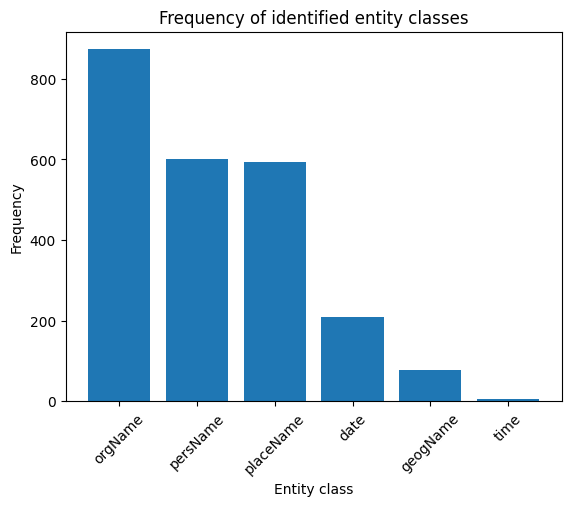

In [10]:
plt.bar(classes.keys(), classes.values())
plt.title("Frequency of identified entity classes")
plt.xlabel("Entity class")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

Creating a dictionary where the keys are entity classes, and the values are lists of words belonging to each class.

In [11]:
entities_by_type = defaultdict(list)

for entity in ner_entities:
    entities_by_type[entity[1]].append(entity[0])

In [12]:
# ner_entities[:10]

Counting occurrences of each entity and sorting them

In [13]:
ner_occ = defaultdict(int)

for entity in ner_entities:
    ner_occ[entity] += 1

ner_occ = dict(sorted(ner_occ.items(), key=lambda item: -item[1]))
top_50_ner = dict(islice(ner_occ.items(), 50))

In [14]:
# ner_occ

Displaying 10 most frequent Named Entities for each identified type.

In [15]:
for entity_class in classes:
    i = 0
    print(f"================== ENTITY TYPE: {entity_class} ==================")
    for entity in ner_occ:
        if entity[1] == entity_class:
            print(entity[0])
            i += 1
        if i == 10:
            break

================== ENTITY TYPE: orgName ==================
IRA
ETF
AUD
Google
GBP
LLC
IRS
Apple
Roth
Roth IRA
================== ENTITY TYPE: persName ==================
Amazon
sald
gdyby być
Trump
Rotha
amazon
jakby być
Mvelopes
gdybyś
Walmart
================== ENTITY TYPE: placeName ==================
USA
amerykański
Indie
Stany Zjednoczone
Kanada
Wielki Brytania
Amerykanów
niemiecki
Illinois
Chiny
================== ENTITY TYPE: date ==================
1099
1 sierpień
1040
2015
2008 rok
10.
1098
2014 rok.
1 czerwiec
2016 rok.
================== ENTITY TYPE: geogName ==================
Europa
europejski
Ameryka
Seria
McDonald's
Australia
Azja
Wall Street
zachód
Afryka
================== ENTITY TYPE: time ==================
30.
14.
00
godzina 2


Displaying 50 most frequent Named Entities including their count and type.

In [16]:
top_50_ner

{('USA', 'placeName'): 84,
 ('IRA', 'orgName'): 49,
 ('amerykański', 'placeName'): 34,
 ('Indie', 'placeName'): 25,
 ('Stany Zjednoczone', 'placeName'): 23,
 ('ETF', 'orgName'): 20,
 ('AUD', 'orgName'): 20,
 ('Google', 'orgName'): 18,
 ('GBP', 'orgName'): 18,
 ('LLC', 'orgName'): 17,
 ('IRS', 'orgName'): 16,
 ('Amazon', 'persName'): 15,
 ('Apple', 'orgName'): 14,
 ('Roth', 'orgName'): 13,
 ('Kanada', 'placeName'): 13,
 ('Wielki Brytania', 'placeName'): 13,
 ('Roth IRA', 'orgName'): 12,
 ('1099', 'date'): 11,
 ('sald', 'persName'): 9,
 ('CPA', 'orgName'): 9,
 ('NYSE', 'orgName'): 9,
 ('1 sierpień', 'date'): 9,
 ('IPO', 'orgName'): 8,
 ('gdyby być', 'persName'): 8,
 ('Amerykanów', 'placeName'): 8,
 ('Trump', 'persName'): 8,
 ('Rotha', 'persName'): 8,
 ('PO', 'orgName'): 8,
 ('amazon', 'persName'): 7,
 ('niemiecki', 'placeName'): 7,
 ('1040', 'date'): 7,
 ('Illinois', 'placeName'): 7,
 ('jakby być', 'persName'): 7,
 ('2015', 'date'): 7,
 ('UE', 'orgName'): 7,
 ('Mvelopes', 'persName'): 7,

In [17]:
import streamlit as st
from spacy import displacy
from spacy_streamlit import visualize_ner

2024-11-15 00:18:39.687 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager


Searching for sentences that contain two different entity types

In [18]:
sentences_with_multiple_entities = []

for text in text_list: # texts
    doc = nlp(text)
    for sent in doc.sents: # sentences
        entities_in_sentence = [(ent.text, ent.label_) for ent in sent.ents]
        entity_types = set([ent.label_ for ent in sent.ents])

        if len(entity_types) >= 2:
            sentences_with_multiple_entities.append(str(sent))
        
        if len(sentences_with_multiple_entities) == 5:
            break
            
    if len(sentences_with_multiple_entities) == 5:
        break

In [20]:
from IPython.display import HTML

for sentence in sentences_with_multiple_entities:
  doc=nlp(sentence)
  options = {"ents": [ent.label_ for ent in doc.ents]}
  html_code=(displacy.render(doc, style="ent", options=options))
  display(HTML(html_code))

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

## Questions

### 1. Which of the method (counting expressions with capital letters vs. NER) worked better for the task concerned with identification of the proper names?

Comparing the top 50 results obtained by each method, I noticed that the method based on counting capitalized expressions is more restrictive, and nearly all elements found this way appear to be correct. Therefore, the results obtained using this method are more precise.

### 2. What are the drawbacks of the method based on capital letters?

This method has some significant limitations. Due to its design, it does not detect all cases we are searching for. For example, using NER (Named Entity Recognition), we identified the word 'amazon' which according to the rules, should have been capitalized. However, because it was written in lowercase, the model failed to recognize it correctly. Another limitation is that this method omits the first words in sentences, which can also lead to missed entities. Beyond that, applying NER provides us with immediate information about the entity type, which can be useful in some cases.

### 3. What are the drawbacks of the method based on NER?

The NER method captures more of the desired values but also returns entries that shouldn't be classified as entities. For instance, the phrase 'gdyby być' was classified as 'persName,' and the word 'niemiecki' as 'placeName,' although it is an adjective that should not be considered an entity type.

### 4. Which of the coarse-grained NER groups has the best and which has the worst results? Try to justify this observation.

The best results were obtained for the 'date' and 'placeName' classes. In both cases, however, there were incorrectly matched values, such as '10.', which in the sentence context did not refer to a date, and 'amerykański' in the 'placeName' class. Nevertheless, overall, the model handled these classes satisfactorily. The greatest difficulties with result accuracy occurred with the 'persName' class. Examples such as 'Amazon,' 'gdyby być,' and 'jakby być' were classified into this category. In this case, the ratio of incorrect results to correct ones was the highest

### 5. Do you think NER is sufficient for identifying different occurrences of the same entity (i.e. consider "USA" and "Stany Zjednoczone" and "Stany Zjednoczone Ameryki Północnej")? If not, can you suggest an algorithm or a tool that would be able to group such names together?

The NER method struggles with identifying the same entity in different forms (as shown in the example provided). Additionally, when using NER, the phrase 'Stany Zjednoczone' was correctly classified as 'placeName,' but it was incorrectly assigned to the 'orgName' category five times. Maybye using Levenshtein distance could help with this issue.

### 6. Can you think of a real world problem that would benefit the most from application of Named Entity Recognition algorithm?

This functionality could be useful in content management systems, where we could automatically identify, for example, authors' names, book titles, event dates, etc., which would facilitate later organization and data retrieval.